# Imports

In [ ]:
# !pip install keras-tuner

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Input

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras_tuner import HyperModel, HyperParameters
from keras_tuner.tuners import RandomSearch

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)


# Functions

In [4]:
def load_and_preprocess(data_path):
    data = pd.read_csv(data_path)
    data['temp_celsius'] = data['temp'] - 273.15
    # data['date'] = pd.to_datetime(data['dt_iso']).dt.date
    data['date'] = pd.to_datetime(data['dt_iso'], format='%Y-%m-%d %H:%M:%S +0000 UTC').dt.date
    data = data.drop(columns=['dt_iso', 'temp'])
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    return data.resample('D').mean()

def split_data_by_time(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    train_size = int(n * train_frac)
    val_size = int(n * val_frac)
    test_size = n - train_size - val_size
    train_df = df[:train_size]
    val_df = df[train_size:train_size+val_size]
    test_df = df[train_size+val_size:]
    return train_df, val_df, test_df


def scale_data(train_df, val_df, test_df, feature_columns, target_column):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_x.fit(train_df[feature_columns])
    scaler_y.fit(train_df[[target_column]])
    train_x = scaler_x.transform(train_df[feature_columns])
    val_x = scaler_x.transform(val_df[feature_columns])
    test_x = scaler_x.transform(test_df[feature_columns])
    train_y = scaler_y.transform(train_df[[target_column]])
    val_y = scaler_y.transform(val_df[[target_column]])
    test_y = scaler_y.transform(test_df[[target_column]])
    dump(scaler_x, 'scaler.joblib')
    return train_x, val_x, test_x, train_y.flatten(), val_y.flatten(), test_y.flatten(), scaler_x, scaler_y

def create_timewindow(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys), time_steps

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()


def evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y):

    y_train_pred_ = model.predict(X_train, verbose=0)
    y_val_pred = model.predict(X_val, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    true_y_train_pred = scaler_y.inverse_transform(y_train_pred_)
    true_y_val_pred = scaler_y.inverse_transform(y_val_pred)
    true_y_test_pred = scaler_y.inverse_transform(y_test_pred)

    true_y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    true_y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    true_y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    train_mse = mean_squared_error(true_y_train, true_y_train_pred)
    val_mse = mean_squared_error(true_y_val, true_y_val_pred)
    test_mse = mean_squared_error(true_y_test, true_y_test_pred)
    print("Train MSE:", train_mse, "Validation MSE:", val_mse, "Test MSE:", test_mse)
    return true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse



def plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps):
    plt.figure(dpi=200)
    plt.figure(figsize=(30, 10))
    # Train
    train_time = train_df.index[time_steps:]
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # Validation
    val_time = val_df.index[time_steps:]
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # Test
    test_time = test_df.index[time_steps:]
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    # Metrics
    plt.text(train_time.min(), true_y_train.max()*1.03, f"Train MSE: {train_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.98, f"Validation MSE: {val_mse:.4f}", fontsize=12)
    plt.text(train_time.min(), true_y_train.max()*0.93, f"Test MSE: {test_mse:.4f}", fontsize=12)

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


# Data Preparation

In [5]:
data_path = "/content/drive/MyDrive/Colab Notebooks/malmo_weather_five_years.csv"

# load and preprocess data
df = load_and_preprocess(data_path)
print(df.head())

# features and target
feature_columns=[col for col in df.columns if col != 'temp_celsius']
target_column='temp_celsius'

# split data by time
train_df, val_df, test_df = split_data_by_time(df, train_frac=0.7, val_frac=0.15)
print("Train Sizes:", train_df.shape, "Validation Sizes:", val_df.shape, "Test Sizes:", test_df.shape)

# scaling
train_scaled_x, val_scaled_x, test_scaled_x, train_scaled_y, val_scaled_y, test_scaled_y, scaler_x, scaler_y = scale_data(train_df, val_df, test_df, feature_columns, target_column)

# time window
X_train, y_train, time_steps = create_timewindow(train_scaled_x, train_scaled_y, time_steps = 5)
X_val, y_val, time_steps = create_timewindow(val_scaled_x, val_scaled_y, time_steps = 5)
X_test, y_test, time_steps = create_timewindow(test_scaled_x, test_scaled_y, time_steps = 5)

input_shape = (X_train.shape[1], X_train.shape[2])

             humidity  wind_speed  clouds_all     pressure   dew_point  \
date                                                                     
2019-01-01  72.583333   17.350000   45.666667  1003.958333  274.824167   
2019-01-02  49.291667   16.275000   13.000000  1021.833333  266.507500   
2019-01-03  68.208333    6.525000   58.791667  1030.000000  269.981667   
2019-01-04  86.750000    8.279167   76.250000  1019.583333  275.467083   
2019-01-05  88.916667    6.129167   53.125000  1018.291667  274.827917   

            temp_celsius  
date                      
2019-01-01      6.366250  
2019-01-02      2.090833  
2019-01-03      1.695000  
2019-01-04      4.332500  
2019-01-05      3.298750  
Train Sizes: (1278, 6) Validation Sizes: (273, 6) Test Sizes: (275, 6)


# Model

In [6]:
model = Sequential([
        GRU(50, input_shape=input_shape,
             kernel_regularizer=l2(0.001)),
        Dense(1)
    ])


optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mse'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                8550      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 8601 (33.60 KB)
Trainable params: 8601 (33.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
start_time = datetime.datetime.now()

history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1,
    callbacks=early_stopping
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/1000
40/40 [==============================] - 3s 15ms/step - loss: 0.0919 - mse: 0.0831 - val_loss: 0.0455 - val_mse: 0.0375
Epoch 2/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0247 - mse: 0.0174 - val_loss: 0.0150 - val_mse: 0.0084
Epoch 3/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0111 - mse: 0.0052 - val_loss: 0.0110 - val_mse: 0.0056
Epoch 4/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0096 - mse: 0.0047 - val_loss: 0.0100 - val_mse: 0.0055
Epoch 5/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0088 - mse: 0.0046 - val_loss: 0.0097 - val_mse: 0.0057
Epoch 6/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0081 - mse: 0.0043 - val_loss: 0.0090 - val_mse: 0.0054
Epoch 7/1000
40/40 [==============================] - 0s 4ms/step - loss: 0.0079 - mse: 0.0045 - val_loss: 0.0088 - val_mse: 0.0054
Epoch 8/1000
40/40 [==============================] - 0s 4ms/step - loss: 0

In [8]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.0026711546815931797 Validation Loss: 0.0031850545201450586 Test Loss: 0.0025750501081347466


In [ ]:
# RNN                Train Loss: 0.005940112750977278  Validation Loss: 0.008608177304267883  Test Loss: 0.01408026646822691
# LSTM               Train Loss: 0.006593023426830769  Validation Loss: 0.009657926857471466  Test Loss: 0.010498634539544582
# LSTM 5 years       Train Loss: 0.0027570798993110657 Validation Loss: 0.0032699054572731256 Test Loss: 0.0026631003711372614
# 5 years LSTM hyper Train Loss: 0.002944508334621787  Validation Loss:  0.0035365233197808266  Test Loss: 0.002884679939597845
# 5 years GRU        Train Loss: 0.0026711546815931797 Validation Loss: 0.0031850545201450586 Test Loss: 0.0025750501081347466

In [9]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 2.324467973622236 Validation MSE: 2.8202917686963107 Test MSE: 2.231743043182819


In [ ]:
# 1 year  RNN        Train MSE: 3.173135618953161  Validation MSE: 4.598381828182215  Test MSE: 7.5215032227643075
# 1 year  LSTM       Train MSE: 1.8786815583616459 Validation MSE: 3.4721521983793577 Test MSE: 3.7493275305443294
# 5 years LSTM       Train MSE: 2.3680083099711053 Validation MSE: 2.8627960229032854 Test MSE: 2.2773346647605055
# 5 years LSTM hyper Train MSE: 2.681002524055421  Validation MSE: 3.2521945379090402 Test MSE: 2.623278167190968
# 5 years GRU        Train MSE: 2.324467973622236 Validation MSE: 2.8202917686963107 Test MSE:  2.231743043182819

<Figure size 1280x960 with 0 Axes>

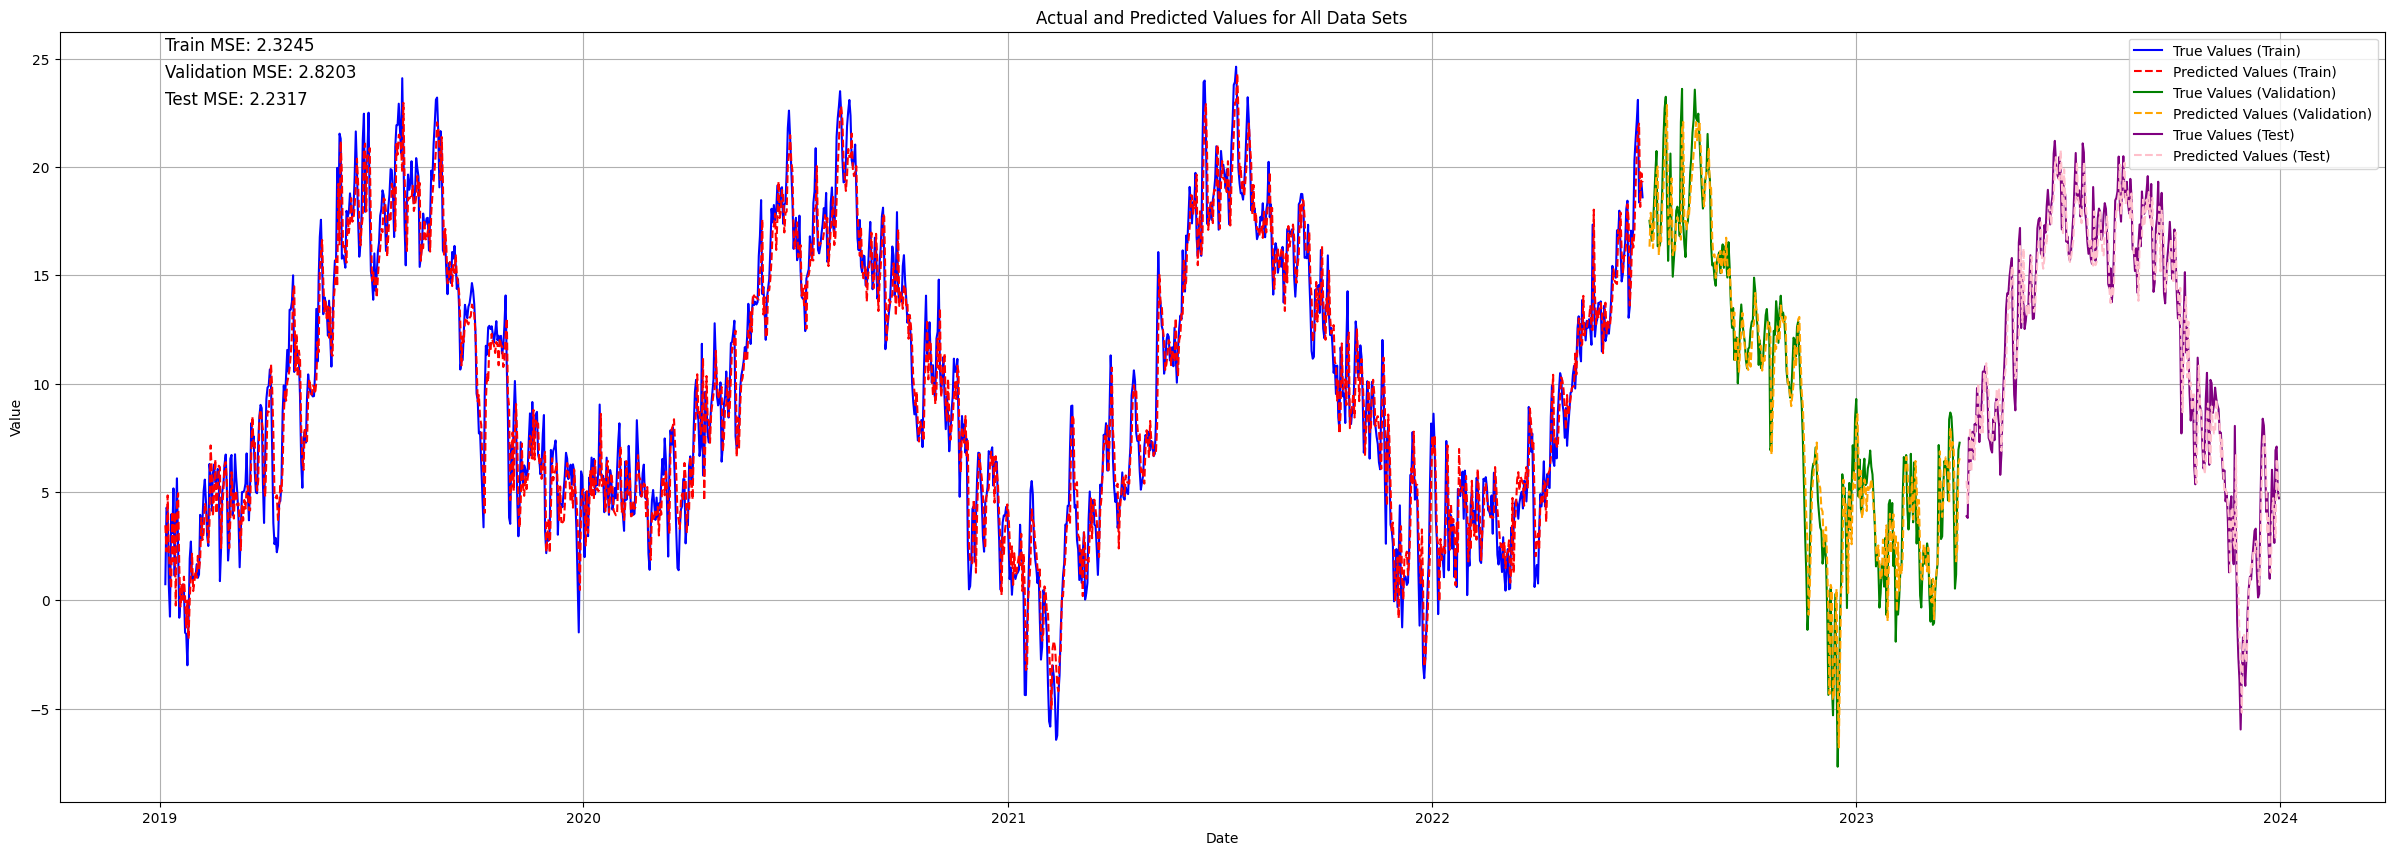

In [10]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)

# Performance Evaluation

# Hyperparameter Optimization

In [11]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))

    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(GRU(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                      return_sequences=(i < hp.Int('num_layers', 1, 5) - 1)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=['mse'])

    return model

In [12]:
random_search_tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='gru_tuning',
    overwrite=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

random_search_tuner.search(X_train, y_train,
                           epochs=250,
                           validation_data=(X_val, y_val),
                           callbacks=[early_stopping])

Trial 20 Complete [00h 00m 19s]
val_loss: 0.007449229247868061

Best val_loss So Far: 0.0034686243161559105
Total elapsed time: 00h 06m 22s


In [13]:
random_search_tuner.results_summary()

Results summary
Results in hyperparam_tuning/gru_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
num_layers: 1
units_0: 256
dropout_0: 0.2
learning_rate: 0.007034231509360318
units_1: 192
dropout_1: 0.1
units_2: 32
dropout_2: 0.30000000000000004
units_3: 64
dropout_3: 0.0
units_4: 480
dropout_4: 0.30000000000000004
Score: 0.0034686243161559105

Trial 03 summary
Hyperparameters:
num_layers: 2
units_0: 224
dropout_0: 0.1
learning_rate: 0.009343666641584668
units_1: 224
dropout_1: 0.4
units_2: 320
dropout_2: 0.1
units_3: 384
dropout_3: 0.4
units_4: 256
dropout_4: 0.30000000000000004
Score: 0.004344927612692118

Trial 04 summary
Hyperparameters:
num_layers: 2
units_0: 96
dropout_0: 0.0
learning_rate: 0.005244853407491271
units_1: 192
dropout_1: 0.0
units_2: 384
dropout_2: 0.30000000000000004
units_3: 32
dropout_3: 0.4
units_4: 416
dropout_4: 0.30000000000000004
Score: 0.005210762843489647

Trial 11 summary
Hyperparameters:
num_la

In [14]:
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

In [15]:
def print_hyperparameters(hyperparameters):
    hp_df = pd.DataFrame(list(hyperparameters.items()), columns=['Hyperparameter', 'Value'])
    print(hp_df)

In [16]:
print_hyperparameters(best_hps.values)

   Hyperparameter       Value
0      num_layers    1.000000
1         units_0  256.000000
2       dropout_0    0.200000
3   learning_rate    0.007034
4         units_1  192.000000
5       dropout_1    0.100000
6         units_2   32.000000
7       dropout_2    0.300000
8         units_3   64.000000
9       dropout_3    0.000000
10        units_4  480.000000
11      dropout_4    0.300000


In [17]:
dump(best_hps, 'best_hps_gru.joblib')

['best_hps_gru.joblib']

In [18]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]

In [19]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               201984    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 203265 (794.00 KB)
Trainable params: 202753 (792.00 KB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [20]:
train_loss = best_model.evaluate(X_train, y_train, verbose=0)
val_loss = best_model.evaluate(X_val, y_val, verbose=0)
test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.003000599564984441 Validation Loss: 0.0034686243161559105 Test Loss: 0.003013251582160592


In [ ]:
# RNN                Train Loss: 0.005940112750977278  Validation Loss: 0.008608177304267883  Test Loss: 0.01408026646822691
# LSTM               Train Loss: 0.006593023426830769  Validation Loss: 0.009657926857471466  Test Loss: 0.010498634539544582
# LSTM 5 years       Train Loss: 0.0027570798993110657 Validation Loss: 0.0032699054572731256 Test Loss: 0.0026631003711372614
# 5 years LSTM hyper Train Loss: 0.002944508334621787  Validation Loss: 0.0035365233197808266 Test Loss: 0.002884679939597845
# 5 years GRU        Train Loss: 0.0026711546815931797 Validation Loss: 0.0031850545201450586 Test Loss: 0.0025750501081347466
# 5 years GRU  hyper Train Loss: 0.003000599564984441  Validation Loss: 0.0034686243161559105 Test Loss: 0.003013251582160592



In [21]:
best_model.save('weather_forecast_gru_tuned.keras')

In [22]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(best_model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y)

Train MSE: 2.895059672339221 Validation MSE: 3.346622464594937 Test MSE: 2.9072669097671744


In [ ]:
# 1 year  RNN        Train MSE: 3.173135618953161  Validation MSE: 4.598381828182215  Test MSE: 7.5215032227643075
# 1 year  LSTM       Train MSE: 1.8786815583616459 Validation MSE: 3.4721521983793577 Test MSE: 3.7493275305443294
# 5 years LSTM       Train MSE: 2.3680083099711053 Validation MSE: 2.8627960229032854 Test MSE: 2.2773346647605055
# 5 years LSTM hyper Train MSE: 2.681002524055421  Validation MSE: 3.2521945379090402 Test MSE: 2.623278167190968
# 5 years GRU        Train MSE: 2.324467973622236 Validation MSE: 2.8202917686963107 Test MSE:  2.231743043182819
# 5 years GRU  hyper Train MSE: 2.895059672339221 Validation MSE: 3.346622464594937  Test MSE:  2.9072669097671744

<Figure size 1280x960 with 0 Axes>

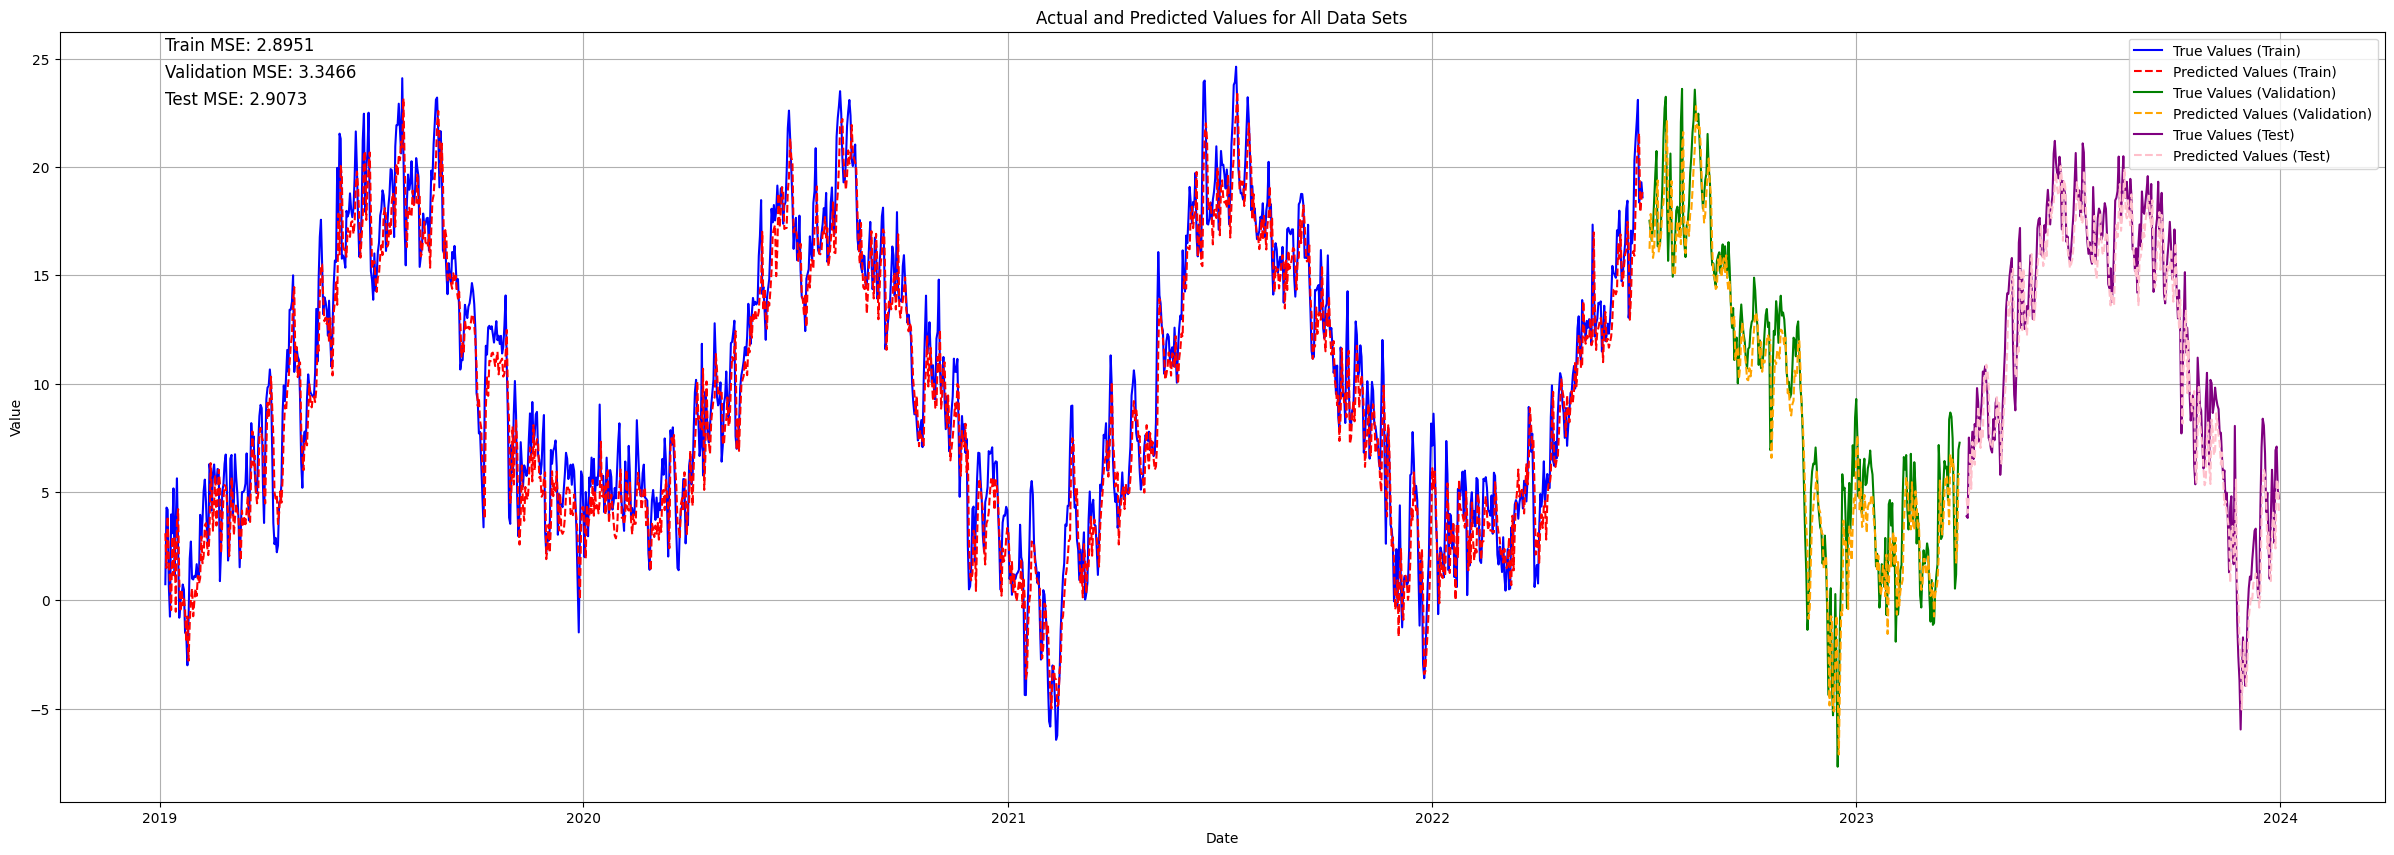

In [23]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)

In [24]:
from keras_tuner.tuners import GridSearch

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))

    num_layers = hp.Int('num_layers', 1, 5)
    for i in range(num_layers):
        model.add(GRU(units=hp.Int('units_' + str(i), min_value=16, max_value=256, step=16),
                      return_sequences=(i < num_layers - 1)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=['mse'])

    return model


grid_search_tuner = GridSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='gru_tuning',
    overwrite=True)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)


In [25]:
grid_search_tuner.search(X_train, y_train,
                         epochs=250,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stopping])

Trial 50 Complete [00h 00m 18s]
val_loss: 0.004836255684494972

Best val_loss So Far: 0.002950680907815695
Total elapsed time: 00h 22m 14s


In [26]:
best_hps = grid_search_tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = grid_search_tuner.get_best_models(num_models=1)[0]

In [27]:
train_loss = best_model.evaluate(X_train, y_train, verbose=0)
val_loss = best_model.evaluate(X_val, y_val, verbose=0)
test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.0023663335014134645 Validation Loss: 0.002950680907815695 Test Loss: 0.0022324821911752224


In [ ]:
# RNN                Train Loss: 0.005940112750977278  Validation Loss: 0.008608177304267883  Test Loss: 0.01408026646822691
# LSTM               Train Loss: 0.006593023426830769  Validation Loss: 0.009657926857471466  Test Loss: 0.010498634539544582
# LSTM 5 years       Train Loss: 0.0027570798993110657 Validation Loss: 0.0032699054572731256 Test Loss: 0.0026631003711372614
# 5 years LSTM hyper Train Loss: 0.002944508334621787  Validation Loss: 0.0035365233197808266 Test Loss: 0.002884679939597845
# 5 years GRU        Train Loss: 0.0026711546815931797 Validation Loss: 0.0031850545201450586 Test Loss: 0.0025750501081347466
# 5 years GRU  hyper Train Loss: 0.003000599564984441  Validation Loss: 0.0034686243161559105 Test Loss: 0.003013251582160592
# 5 years GRU grid   Train Loss: 0.0023663335014134645 Validation Loss: 0.002950680907815695  Test Loss: 0.0022324821911752224



In [28]:
true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse = evaluate_predictions(best_model,
                                                                                                                                                 X_train,
                                                                                                                                                 y_train,
                                                                                                                                                 X_val,
                                                                                                                                                 y_val,
                                                                                                                                                 X_test,
                                                                                                                                                 y_test,
                                                                                                                                                 scaler_y)

Train MSE: 2.2831027293019974 Validation MSE: 2.8468970232820157 Test MSE: 2.1539596425750744


In [ ]:
# 1 year  RNN        Train MSE: 3.173135618953161  Validation MSE: 4.598381828182215  Test MSE: 7.5215032227643075
# 1 year  LSTM       Train MSE: 1.8786815583616459 Validation MSE: 3.4721521983793577 Test MSE: 3.7493275305443294
# 5 years LSTM       Train MSE: 2.3680083099711053 Validation MSE: 2.8627960229032854 Test MSE: 2.2773346647605055
# 5 years LSTM hyper Train MSE: 2.681002524055421  Validation MSE: 3.2521945379090402 Test MSE: 2.623278167190968
# 5 years GRU        Train MSE: 2.324467973622236 Validation MSE:  2.8202917686963107 Test MSE:  2.231743043182819
# 5 years GRU  hyper Train MSE: 2.895059672339221 Validation MSE:  3.346622464594937  Test MSE:  2.9072669097671744
# 5 years GRU grid   Train MSE: 2.2831027293019974 Validation MSE: 2.8468970232820157 Test MSE:  2.1539596425750744

<Figure size 1280x960 with 0 Axes>

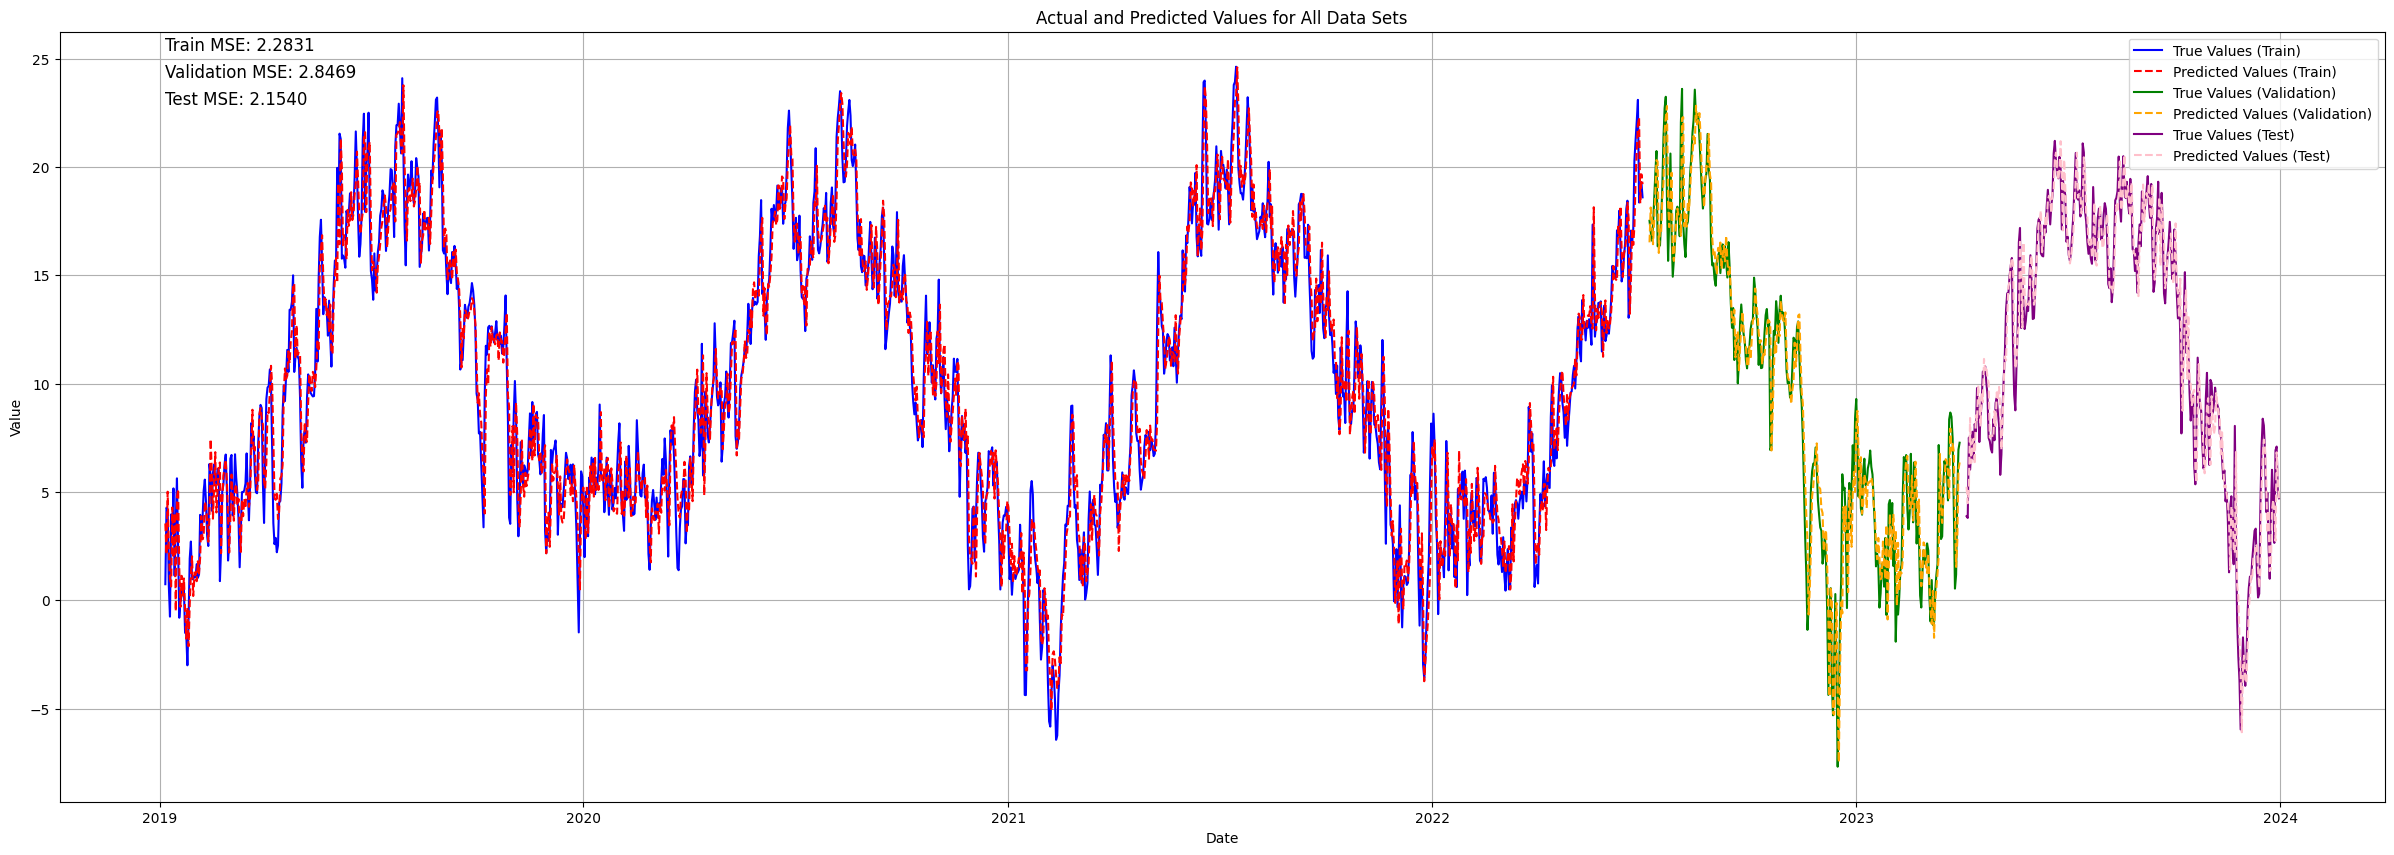

In [29]:
plot_predictions_with_metrics(train_df, val_df, test_df, true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, true_y_test, true_y_test_pred, train_mse, val_mse, test_mse, time_steps)